# Валидация модели

In [1]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from tqdm import tqdm
from warnings import filterwarnings

sys.path.insert(0, "../") # Для импорта custom_module

from custom_module.market_and_cycle_model.agents import Buyer, Seller, House
from custom_module.market_and_cycle_model.world import WorldModel

filterwarnings("ignore")

In [2]:
kdzh = pd.read_csv('../data/kdzh.csv')
price = pd.read_csv('../data/real_estate_deals_primary_market.csv')
cb_mortgage = pd.read_csv('../data/cb_mortgage_data.csv')
new_kdzh = pd.DataFrame(columns=kdzh.columns)
wages = pd.read_csv('../data/nominal_wages.csv')

In [3]:
for i in range(16):
    new_kdzh.loc[i*3] = kdzh.loc[i].copy()
    new_kdzh.loc[i*3+1] = kdzh.loc[i].copy()
    new_kdzh.loc[i*3+2] = kdzh.loc[i].copy()

cb_mortgage['inflation'] = (1 + cb_mortgage['inflation']/100) ** (1/12)
price['ipc'] = [np.prod(cb_mortgage['inflation'][:i]) for i in range(len(cb_mortgage))]
price['real_price'] = price['price'] / price['ipc']

wages['real_wages'] = wages['wage'] / price['ipc']
wages['real_wage_index'] = wages['real_wages'] / wages['real_wages'][0]

In [4]:
wages

,month,wage,real_wages,real_wage_index
0,1,46674,46674.000000,1.000000
1,2,47257,46975.965938,1.006470
2,3,50948,50341.490858,1.078577
3,4,49306,48456.836884,1.038198
4,5,50747,49631.436014,1.063364
5,6,52123,50764.303527,1.087636
6,7,50145,48666.820219,1.042697
7,8,47649,46121.308627,0.988158
8,9,49259,47581.292558,1.019439
9,10,49539,47760.775853,1.023284


# Simulation

In [5]:
model = WorldModel(num_buyers=10000)
model.mortgage_rate = 0.08
model.youth_mortgage_rate = 1
model.family_mortgage_rate = 1
for month in tqdm(range(360)):
    if (month >= 180) and (month < 228):
        model.mortgage_rate = cb_mortgage.loc[month-180]['rate']/100
    model.step()

100%|██████████| 360/360 [02:56<00:00,  2.04it/s]


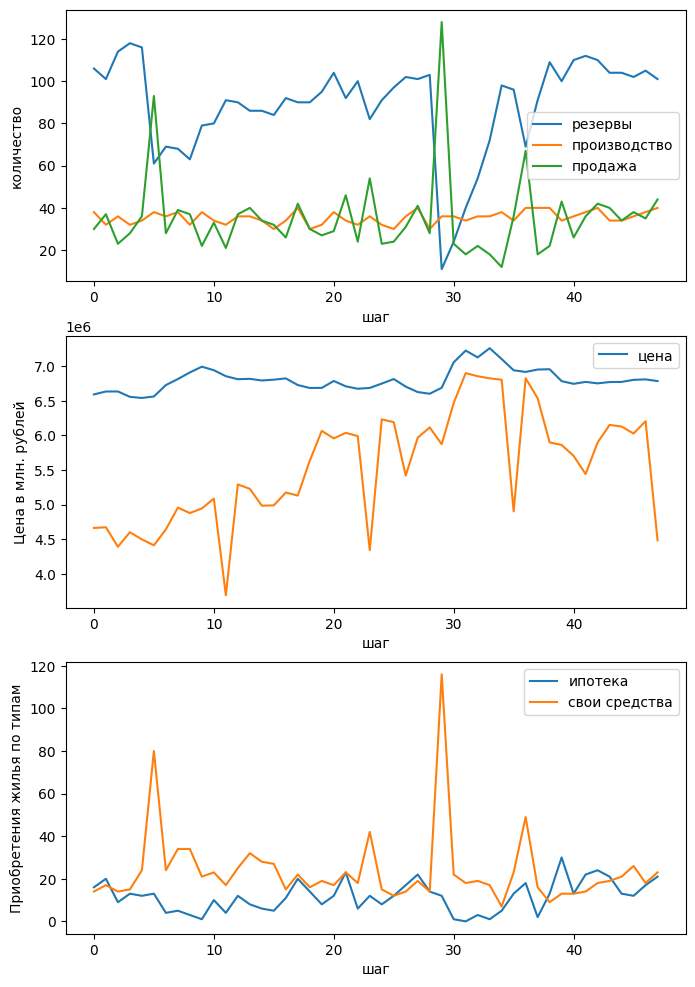

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))

ax1.plot(model.datacollector.get_model_vars_dataframe()[['alt_reserve', 'produce', 'sold']][180:228].reset_index(drop=True))
ax1.legend(['резервы', 'производство', 'продажа'])
ax1.set_ylabel('количество')
ax1.set_xlabel('шаг')

ax2.plot(model.datacollector.get_model_vars_dataframe()[['sold_price']][180:228].reset_index(drop=True))
ax2.plot(price['real_price']*64/wages['real_wage_index'])
ax2.legend(['цена'])
ax2.set_ylabel('Цена в млн. рублей')
ax2.set_xlabel('шаг')


ax3.plot(model.datacollector.get_model_vars_dataframe()[['cash_bought', 'mortgages_bought']][180:228].reset_index(drop=True))
ax3.legend(['ипотека', 'свои средства'])
ax3.set_ylabel('Приобретения жилья по типам')
ax3.set_xlabel('шаг');


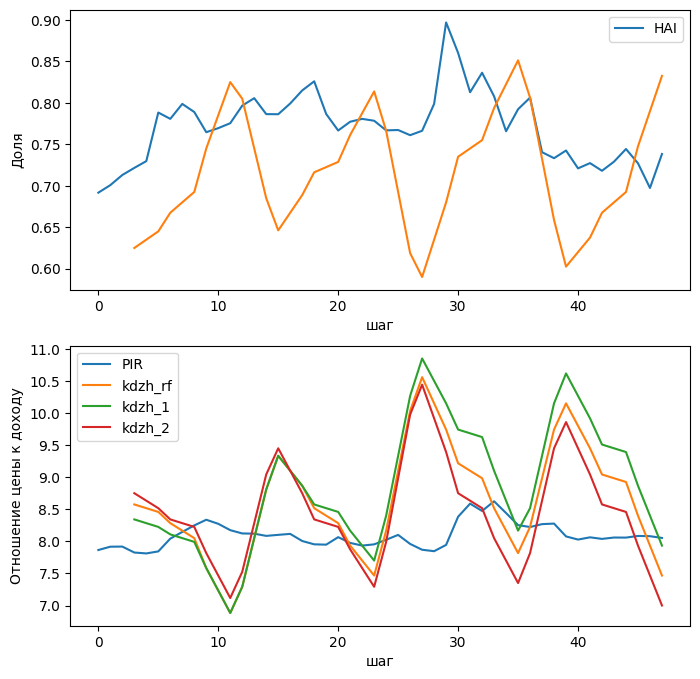

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))

ax1.plot(model.datacollector.get_model_vars_dataframe()[['hai']][180:228].reset_index(drop=True))
ax1.plot(new_kdzh['hai'].rolling(4).mean()/2)
ax1.legend(['HAI'])
ax1.set_ylabel('Доля')
ax1.set_xlabel('шаг')

ax2.plot(model.datacollector.get_model_vars_dataframe()[['pir']][180:228].reset_index(drop=True))
ax2.plot(new_kdzh['kdzh_rf'].rolling(4).mean()*2*35/30)
ax2.plot(new_kdzh['kdzh_1'].rolling(4).mean()*2*35/30)
ax2.plot(new_kdzh['kdzh_2'].rolling(4).mean()*2*35/30)
ax2.legend(['PIR','kdzh_rf','kdzh_1','kdzh_2'])
ax2.set_ylabel('Отношение цены к доходу')
ax2.set_xlabel('шаг');


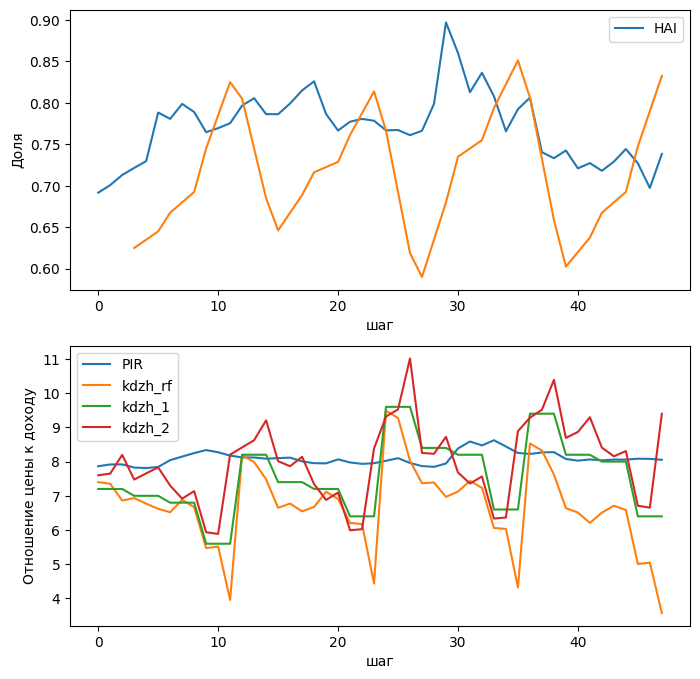

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))

ax1.plot(model.datacollector.get_model_vars_dataframe()[['hai']][180:228].reset_index(drop=True))
ax1.plot(new_kdzh['hai'].rolling(4).mean()/2)
ax1.legend(['HAI'])
ax1.set_ylabel('Доля')
ax1.set_xlabel('шаг')

ax2.plot(model.datacollector.get_model_vars_dataframe()[['pir']][180:228].reset_index(drop=True))
ax2.plot(new_kdzh['kdzh_rf']/wages['real_wage_index']*2)
ax2.plot(new_kdzh['kdzh_1']*2)
ax2.plot(new_kdzh['kdzh_2']*wages['real_wage_index']*2)
ax2.legend(['PIR','kdzh_rf','kdzh_1','kdzh_2'])
ax2.set_ylabel('Отношение цены к доходу')
ax2.set_xlabel('шаг');